# Find Teleconnections (precursor regions) via correlation maps 

In [1]:
import os, inspect
%load_ext autoreload
%autoreload 2
from RGCPD import RGCPD
from RGCPD import BivariateMI
import class_BivariateMI, functions_pp
import numpy as np
from IPython.display import Image
main_dir = RGCPD.main_dir
print(main_dir)
import netCDF4 as nc

/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))


/Users/semvijverberg/surfdrive/Scripts/RGCPD


/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: No module named 'networkx'
  warnings.warn(str(e))


## RGCPD docstring
Class to study teleconnections of a Response Variable* of interest.

    Methods to extract teleconnections/precursors:
        - BivariateMI (supporting (partial) correlation maps)
        - EOF analysis

    BivariateMI (MI = Mutual Information) is class which allows for a
    statistical test in the form:
    MI(lon,lat) = for gc in map: func(x(t), y(t)),
    where map is a (time,lon,lat) map and gc stands for each gridcell/coordinate
    in that map. The y timeseries is always the same 1-dimensional timeseries of
    interest (i.e. the Response Variable). At this point, only supports the
    correlation analysis. Once the significance is attributed, it is stored
    in the MI map. Precursor regions are found by clustering the
    significantly (correlating) gridcells (+ and - regions are separated)
    and extract their spatial mean (or spatial covariance) timeseries.

    *Sometimes Response Variable is also called Target Variable.

    Parameters
    ----------
    list_of_name_path : list, optional
        list of (name, path) tuples defining the input data.

        Convention: first entry should be (name, path) of target variable (TV).
        e.g. list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]

        TVpath input data supports .nc/.h5 or .csv file format.
        if using output of the clustering:
            'TVname' should refer the name
            you have given the timeseries on the dimesion 'cluster', i.e.
            xrTV.sel(cluster=TVname)
        elif using .h5 the index should contain a datetime axis.
        elif using .csv the first columns should be [year, month, day, value]


        prec_path input data supports only .nc
        'prec_name' is a string/key that can be chosen freely, does not have
        to refer to the variable in the .nc file.
        Each prec_path .nc file should contain only a single variable
        of format (time, lat, lon).
    list_for_EOFS : list, optional
        list of EOF classes, see docs EOF?
    list_import_ts : list, optional
        Load in precursor 1-d timeseries in format:
        [(name1, path_to_h5_file1), [(name2, path_to_h5_file2)]]
        precursor_ts can handle the RGCPD cross-validation format.
    start_end_TVdate : tuple, optional
        tuple of start- and enddate for target variable in
        format ('mm-dd', 'mm-dd').
    tfreq : int, optional
        The default is 10, if using time_mean_periods, tfreq should be None.
    start_end_date : tuple, optional
        tuple of start- and enddate for data to load in
        format ('mm-dd', 'mm-dd'). default is ('01-01' - '12-31')
    start_end_year : tuple, optional
        default is to load all years
    path_outmain : [str, bool], optional
        Root folder for output. If None, default is your
        '/users/{username}/Download' path.
    append_pathsub: str, optional
        The first subfolder will be created below path_outmain, to store
        output data & figures. The append_pathsub1 argument allows you to
        manually add some hash or string refering to some experiment.
    save : bool, optional
        If you want to save figures, data and text output automatically.
    verbosity : int, optional
        Regulate the amount of feedback given by the code.
        The default is 1.

    Returns
    -------
    initialization of the RGCPD class

In [2]:
path_test = os.path.join(main_dir, 'data') # path of test data
# define input by filling list_of_name_path: 
# format list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]
list_of_name_path = [(3, os.path.join(path_test, 'tf5_nc5_dendo_80d77.nc')),
                    ('sst', os.path.join(path_test,'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))]

# define analysis:
list_for_MI = [BivariateMI(name='sst', func=class_BivariateMI.corr_map, 
                           alpha=.01, FDR_control=True, lags=np.array([1,2]), 
                           distance_eps=700, min_area_in_degrees2=5)]

In [3]:
?BivariateMI

Init signature:
BivariateMI(
    name,
    filepath: str = None,
    func=None,
    kwrgs_func={},
    alpha: float = 0.05,
    FDR_control: bool = True,
    lags=array([1]),
    lag_as_gap: bool = False,
    distance_eps: int = 400,
    min_area_in_degrees2=3,
    group_lag: bool = False,
    group_split: bool = True,
    calc_ts='region mean',
    selbox: tuple = None,
    use_sign_pattern: bool = False,
    use_coef_wghts: bool = True,
    path_hashfile: str = None,
    hash_str: str = None,
    dailytomonths: bool = False,
    n_cpu=1,
    n_jobs_clust=-1,
    verbosity=1,
)
Docstring:      <no docstring>
Init docstring:
Parameters
----------
name : str
    Name that links to a filepath pointing to a Netcdf4 file.
filepath : str
    Optionally give manual filepath to Netcdf4. Normally this is
    automatically done by the RGCPD framework.
func : function to apply to calculate the bivariate
    Mutual Informaiton (MI), optional
    The default is applying a correlation map.
kwrgs_fu

# Time-handling subseasonal mode (DJF)

In [4]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=10, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('02-28', '12-01'), # <- defining DJF target period 
           start_end_date=('02-28', '07-01'), # <- Loading subset of data for computational efficiency
           path_outmain=os.path.join(main_dir,'data'))

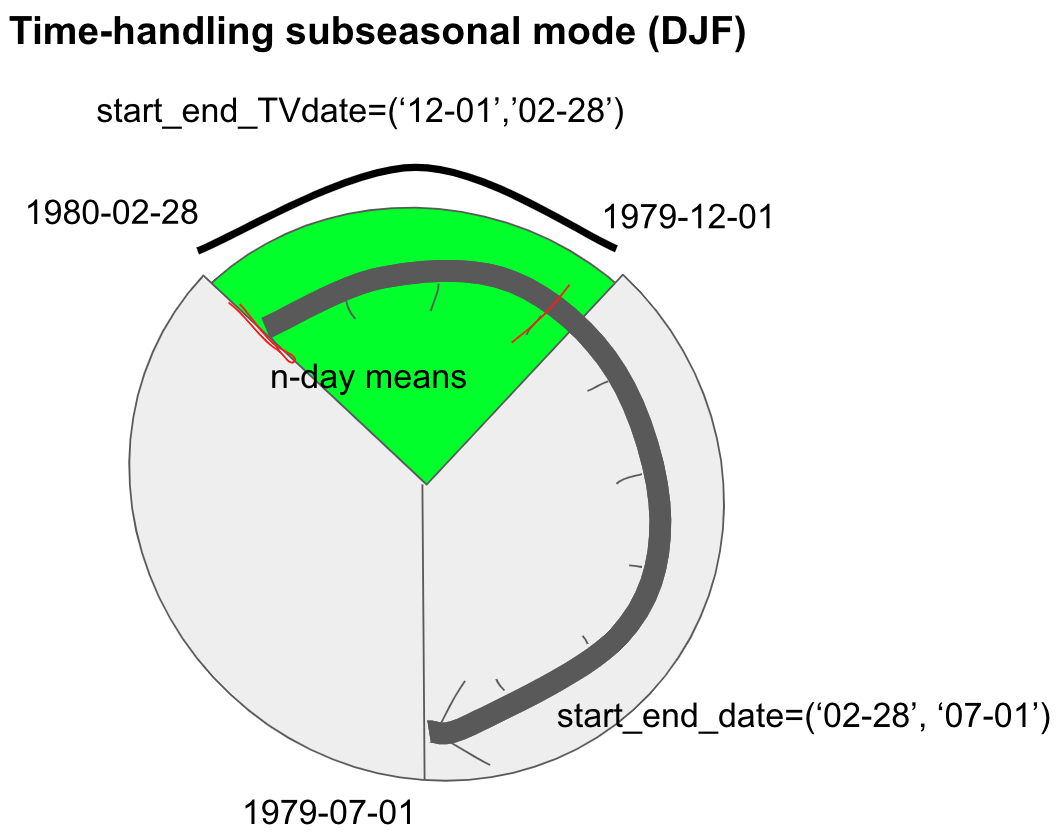

In [5]:
Image(filename = "./data/subseasonal_mode_DJF.png", width = 400, height = 200)

# Time-handling subseasonal mode (JJA)

In [6]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=10, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('06-01', '08-31'), # <- defining target period 
           path_outmain=os.path.join(main_dir,'data'))

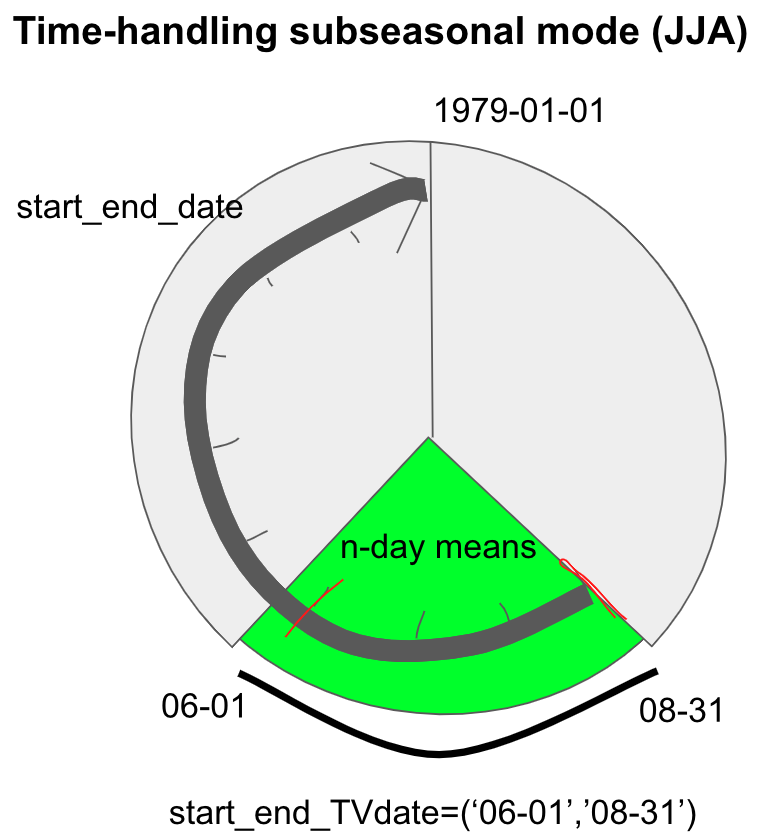

In [7]:
Image(filename = "./data/subseasonal_mode_JJA.png", width = 400, height = 200)

Note, if loading in monthly data, the exact same reasoning is followed. Where tfreq now stands for n-month means instead of n-day means.

sorting latitude
Plotting Corr maps xrclustered, split 0, lag 0


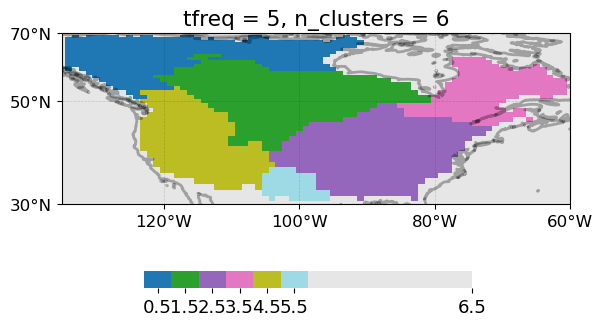

In [8]:
# if TVpath contains the xr.DataArray that is clustering beforehand, we can have a look at the spatial regions.
rg.plot_df_clust()

In [9]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)

Loaded pre-processed data of sst



Option for pp_precursors to vary pre-processing of datasets by given a list as an argument:
An example: detrend=[True, {'sm1':False, 'sm2':False}]. This input means that default argument is True, except the variables sm1 and sm2 got a different argument. The precursor names sm1 and sm2 should refer to the names given in list_of_name_path.

### Post-processing Target Variable

In [10]:
rg.pp_TV?

Signature:
rg.pp_TV(
    name_ds='ts',
    detrend=False,
    anomaly=False,
    kwrgs_core_pp_time: dict = {},
    ext_annual_to_mon: bool = True,
    TVdates_aggr: bool = False,
)
Docstring:
Load and pre-process target variable/response variable.

Parameters
----------
name_ds : str, optional
    name of 1-d timeseries in .nc file. The default is 'ts'.
detrend : bool or dict, optional
    If True: linear scipy detrending, see sp.signal.detrend docs.
    With dict, {'method':'loess'}, loess detrending can be called.
    Extra loess argument can be passed as well, see core_pp.detrend_wrapper?
    The default is True.
anomaly : bool, optional
    calculate anomaly verus climatology. The default is False.
kwrgs_core_pp_time: dict, {}
    see xr_core_pp_time? for optional arguments
    - start_end_year selection is done prior to detrend & anomoly.
ext_annual_to_mon : bool, optional
    if tfreq is None and target variable contain one-value-per-year,
    the target is extended to match the

sorting latitude
Start linear detrending ...
Done
Visual test on 0th observationusing absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
original tfreq of imported response variable is converted to desired 10 (daily) means


/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:706: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=_closed_on_date, freq=_tfreq,
/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:736: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=dates_aggr[-1], freq=_tfreq,


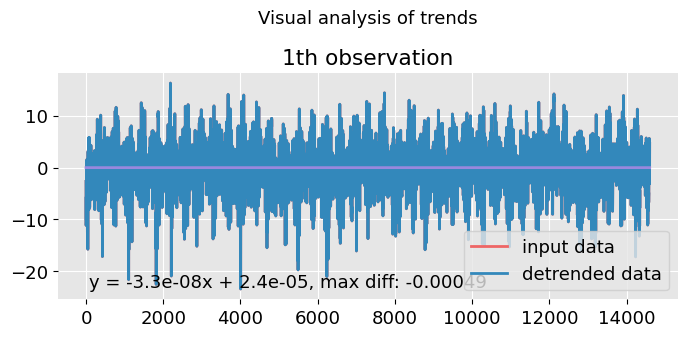

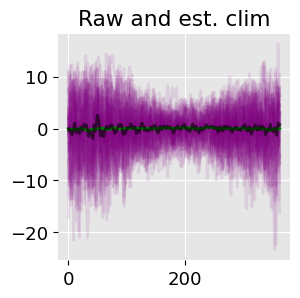

In [11]:
rg.pp_TV(detrend=True, anomaly=True)

In [12]:
rg.df_fullts

,3ts
1979-01-09,-7.601616
1979-01-19,-2.785106
1979-01-29,-5.305454
1979-02-08,-8.257336
1979-02-18,-5.436037
...,...
2018-07-18,0.193873
2018-07-28,-2.411315
2018-08-07,0.672068
2018-08-17,-0.586045


In [13]:
rg.traintest?

Signature:
rg.traintest(
    method: Union[str, bool] = None,
    seed=1,
    gap_prior: int = None,
    gap_after: int = None,
    kwrgs_events=None,
    subfoldername=None,
)
Docstring:
Splits the training and test dates. Only training data will be used
for any analysis/model tuning including correlation maps, causal
inference, transforming data, fitting sk-lean models. Only
pre-processing (detrending/anomaly) is done on entire dataset.

method : str or bool, optional
    Referring to method to split train test, see options for method below.
    default is False.
seed : int, optional
    The seed to draw random samples for train test split, default is 1.
kwrgs_events : dict, optional
    Kwrgs needed to create binary event timeseries, which was used to
    create stratified folds. See func_fc.Ev_timeseries? for more info.
gap_prior : int, optional
    Possibility to exclude years (or train-test groups) prior to the
    test datapoints to avoid train-test leakage. Note, not advisable


In [14]:
rg.traintest(method='leave_10', gap_prior=1, gap_after=1, seed=2)
# rg._get_testyrs()[0] # see test years

In [15]:
rg.calc_corr_maps() 

/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:706: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=_closed_on_date, freq=_tfreq,
/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:736: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=dates_aggr[-1], freq=_tfreq,



sst - calculating correlation maps
Progress traintest set 100%, trainsize=(270dp, 75%)



Plotting sst
Plotting Corr maps sst, split 0, lag 1
Plotting Corr maps sst, split 0, lag 2


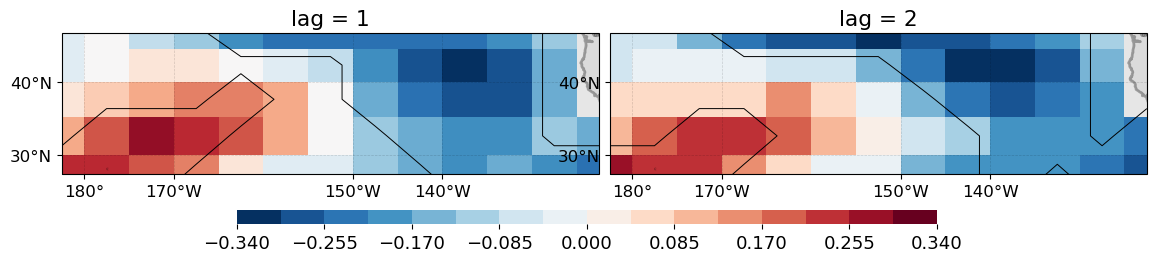

In [16]:
rg.plot_maps_corr()

In [17]:
rg.cluster_list_MI()

Plotting Corr maps sst_labels_init, split 0, lag 1
Plotting Corr maps sst_labels_init, split 1, lag 1
Plotting Corr maps sst_labels_init, split 2, lag 1
Plotting Corr maps sst_labels_init, split 3, lag 1
Plotting Corr maps sst_labels_init, split 0, lag 2
Plotting Corr maps sst_labels_init, split 1, lag 2
Plotting Corr maps sst_labels_init, split 2, lag 2
Plotting Corr maps sst_labels_init, split 3, lag 2


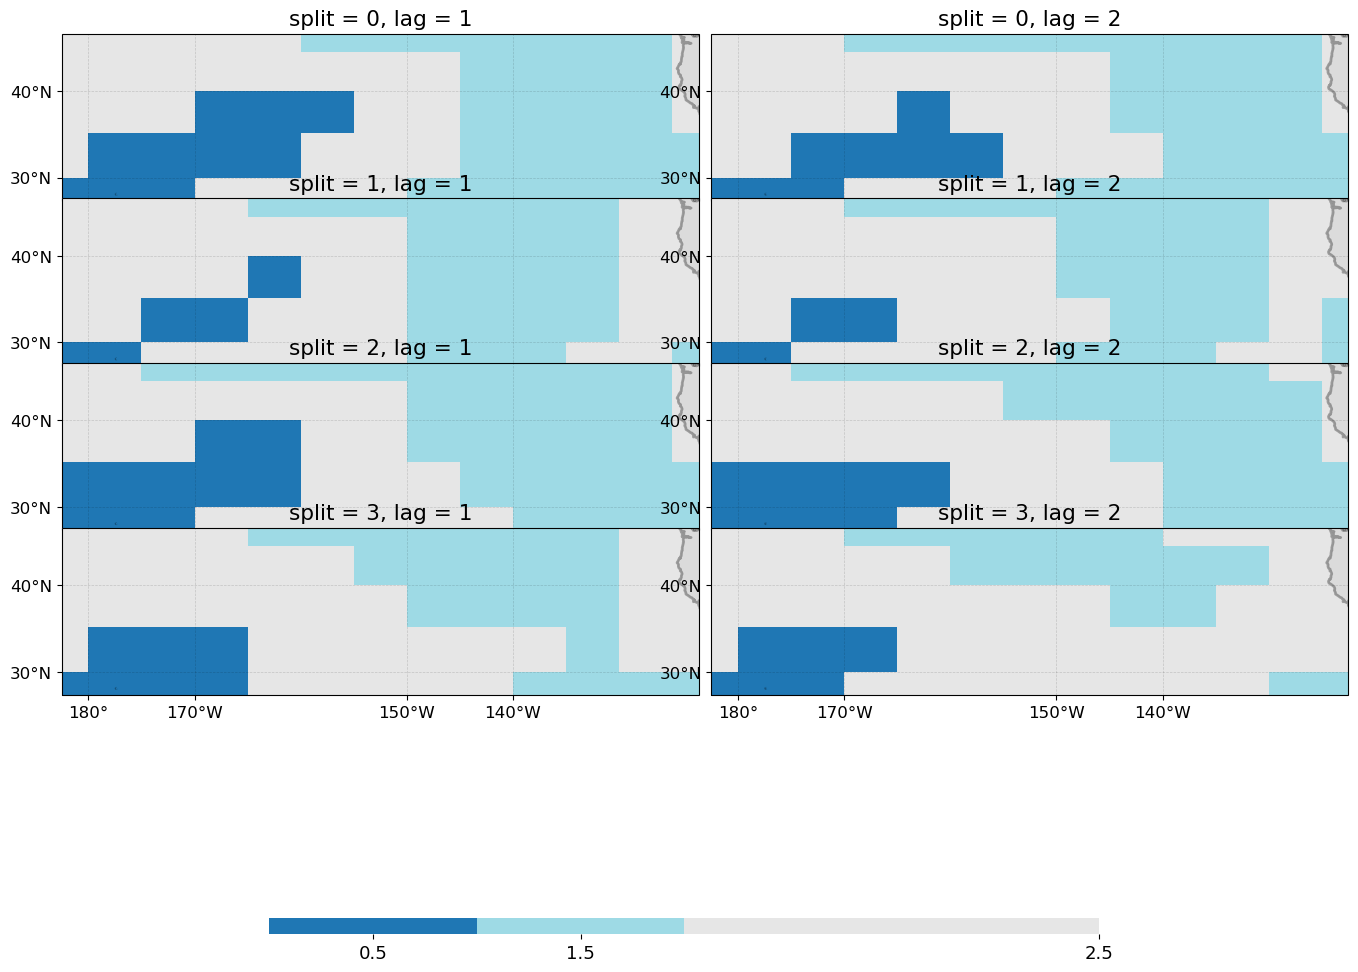

In [18]:
rg.quick_view_labels(mean=False) 

In [19]:
rg.get_ts_prec()


Getting MI timeseries


/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:706: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=_closed_on_date, freq=_tfreq,
/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/functions_pp.py:736: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  dates_aggr =  pd.date_range(end=dates_aggr[-1], freq=_tfreq,


There are [4, 4, 4, 4] regions in total (list of different splits)


From the correlation (BivariateMI) map, the timeseries are named according the format:
{lag}..{region label}..{precursor name}, where precursor name is defined in list_of_name_path. 

In [20]:
rg.df_data.columns

Index(['3ts', '1..1..sst', '1..2..sst', '2..1..sst', '2..2..sst',
       'TrainIsTrue', 'RV_mask'],
      dtype='object')

## Train-test cross-validation and Response Variable mask handling

- The different train-test folds are organized in the first level index.
- Each fold contains precursor timeseries that were extracted from only training data.
- The Training data is specified by the TrainIsTrue mask.
- The Response Variable mask defined the dates to predict 
- The RV_mask the anker for lag shifting the precursors.

The last two columns should be always present. 
- The RV_mask is defined by the start_end_TVdate.
- The TrainIsTrue is defined by the method for cross-validation.


In [21]:
# Example lag shifting
import func_models as fc_utils
fc_utils.apply_shift_lag(rg.df_splits.loc[0].copy(), lag_i=1)

,TrainIsTrue,x_fit,y_fit,x_pred,y_pred
1979-01-09,0,False,False,False,False
1979-01-19,0,False,False,False,False
1979-01-29,0,False,False,False,False
1979-02-08,0,False,False,False,False
1979-02-18,0,False,False,False,False
...,...,...,...,...,...
2018-07-18,1,True,True,True,True
2018-07-28,1,True,True,True,True
2018-08-07,1,True,True,True,True
2018-08-17,1,True,True,True,True


## Causal Discovery using Tigramite

In [22]:
rg.PCMCI_df_data(tigr_function_call='run_pcmci',
                 kwrgs_tigr={'tau_min': 0,
                             'tau_max': 1,
                             'pc_alpha': 0.05,
                             'max_conds_dim': 2,
                             'max_combinations': 2,
                             'max_conds_py': 2,
                             'max_conds_px': 2})

Progress causal inference - traintest set 100%

In [23]:
rg.PCMCI_get_links?

Signature:
rg.PCMCI_get_links(
    var: str = None,
    alpha_level: float = 0.05,
    FDR_cv='fdr_bh',
)
Docstring:
Parameters
----------
var : str, optional
    Specify variable you want to retrieve links for. If None, returns
    links toward target variable
alpha_level : float, optional
    significance threshold. The default is .05.

Returns
-------
DataFrame of MCI coefficients and alpha values _toward_ var.
File:      ~/surfdrive/Scripts/RGCPD/RGCPD/class_RGCPD.py
Type:      method


In [24]:
rg.PCMCI_get_links(var=rg.TV.name, alpha_level=.05)
rg.df_links

0      1
0 3ts        False   True
  1..1..sst   True  False
  1..2..sst   True  False
  2..1..sst  False  False
  2..2..sst   True  False
1 3ts        False   True
  1..1..sst   True  False
  1..2..sst   True  False
  2..1..sst  False  False
  2..2..sst   True  False
2 3ts        False   True
  1..1..sst  False  False
  1..2..sst   True  False
  2..1..sst  False  False
  2..2..sst  False  False
3 3ts        False   True
  1..1..sst  False  False
  1..2..sst   True  False
  2..1..sst  False  False
  2..2..sst  False  False

/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/wrapper_PCMCI.py:555: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_robustness = df_links.sum(axis=0, level=1)
/Users/semvijverberg/surfdrive/Scripts/RGCPD/RGCPD/wrapper_PCMCI.py:567: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  df_MCIvals = pd.concat(MCIvals_s, keys=splits).mean(axis=0, level=1)


TypeError: plot_graph() missing 1 required positional argument: 'graph'

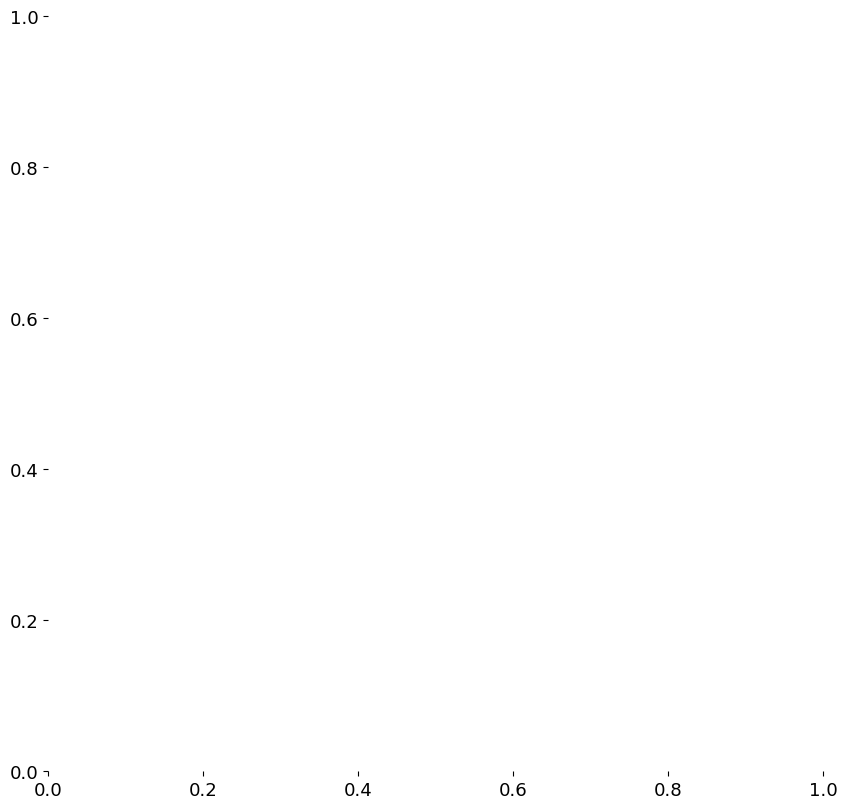

In [26]:
rg.PCMCI_plot_graph()



Plotting all fields significant at alpha_level_tig, while conditioning on parents that were found in the PC step
Plotting Corr maps sst_labels, split 0, lag sst_labels
Plotting Corr maps sst_labels, split 0, lag sst_labels_tigr


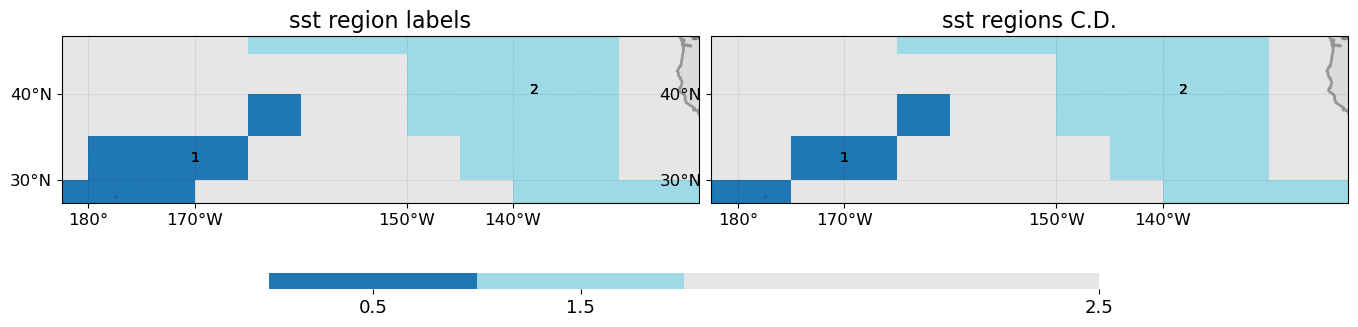

Plotting Corr maps sst_labels, split 0, lag sst_labels
Plotting Corr maps sst_labels, split 0, lag sst_labels_tigr


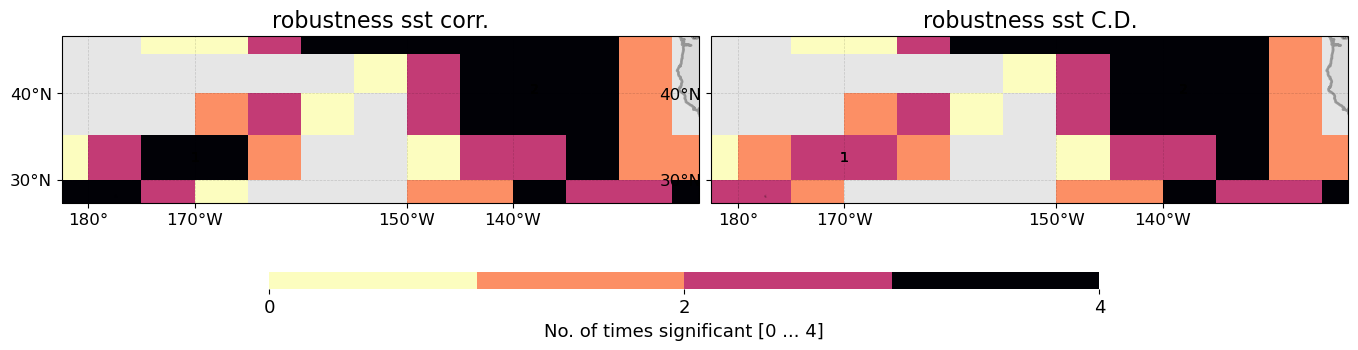


Plotting all fields significant at alpha_level_tig, while conditioning on parents that were found in the PC step
Plotting Corr maps sst_corr_and_tigr, split 0, lag sst_corr
Plotting Corr maps sst_corr_and_tigr, split 0, lag sst_corr_tigr


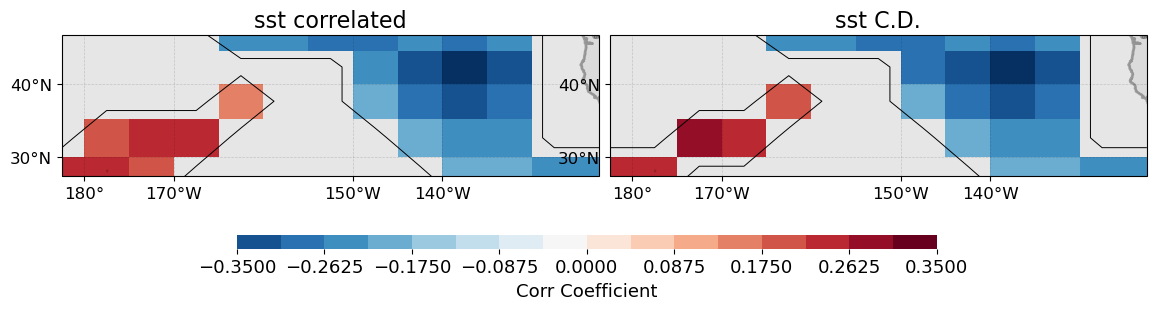

In [25]:
# on the left you see all the extraction precursor regions, on the right you see the regions which were found Conditionally Dependent (~Causal)
rg.plot_maps_sum()

In [26]:
# Deprecated: rg.df_ParCorr_sum 

## Functionality for Causal Inference
(Define your own Conditional Independence tests)

In [27]:
import wrapper_PCMCI
corr, pvals = wrapper_PCMCI.df_data_Parcorr(rg.df_data, 
                                            target='3ts',
                                            keys=['1..2..sst'],
                                            z_keys=['1..1..sst'],
                                            z_lag=1)
pvals

,,0,1,2,3
x,z,,,,
1..2..sst,1..1..sst,1.241778e-12,7.876834e-14,1.526696e-10,7.415270e-10


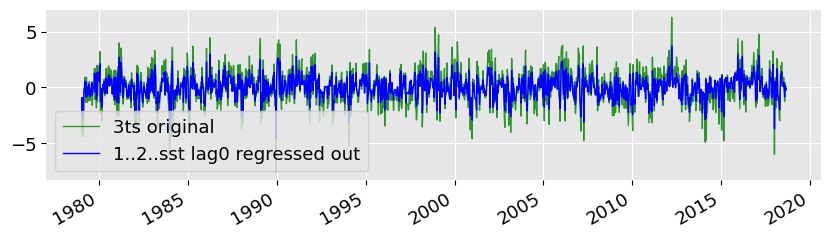

In [28]:
df_trans = rg.transform_df_data()

df_z_removed = wrapper_PCMCI.df_data_remove_z(df_trans,
                                              keys=['3ts'],
                                              z_keys=['1..2..sst'],
                                              plot=True)

# Forecasting pipeline 1

In [56]:
import func_models as fc_utils
from stat_models_cont import ScikitModel
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV


# choose type prediciton (continuous or probabilistic) by making comment #
prediction = 'continuous'   
# prediction = 'events' ; q = .66 # quantile threshold for event definition

if prediction == 'continuous':
    model = ScikitModel(Ridge, verbosity=0)
    # You can also tune parameters by passing a list of values. Then GridSearchCV from sklearn will 
    # find the set of parameters that give the best mean score on all kfold test sets. 
    # below we pass a list of alpha's to tune the regularization.
    alphas = list(np.concatenate([[1E-20],np.logspace(-5,0, 6), np.logspace(.01, 2.5, num=25)]))                       
    kwrgs_model = {'scoringCV':'neg_mean_absolute_error',
                   'kfold':5,
                   'alpha':alphas} # large a, strong regul.
elif prediction == 'events':
    model = ScikitModel(LogisticRegressionCV, verbosity=0)
    kwrgs_model = {'kfold':5,
                   'scoring':'neg_brier_score'}

    

target_ts = rg.TV.RV_ts ; 
target_ts = (target_ts - target_ts.mean()) / target_ts.std()
if prediction == 'events':
    if q >= 0.5:
        target_ts = (target_ts > target_ts.quantile(q)).astype(int)
    elif q < .5:
        target_ts = (target_ts < target_ts.quantile(q)).astype(int)
    BSS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).BSS
    score_func_list = [BSS, fc_utils.metrics.roc_auc_score]
    
elif prediction == 'continuous':
    RMSE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).RMSE
    MAE_SS = fc_utils.ErrorSkillScore(constant_bench=float(target_ts.mean())).MAE
    score_func_list = [RMSE_SS, fc_utils.corrcoef, MAE_SS]
        
    
out = rg.fit_df_data_ridge(target=target_ts,
                           keys=rg.df_data.columns[1:-2],
                           fcmodel=model,
                           kwrgs_model=kwrgs_model,
                           transformer=False,
                           tau_min=1, tau_max=3)
predict, weights, model_lags = out

df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 rg.df_data.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
lag = 1
if prediction == 'events':
    print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
          'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
          'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
          '\nTrain score\n',
          'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
          'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))
elif prediction == 'continuous':
    print(model.scikitmodel.__name__, '\n', 'Test score\n',
              'RMSE {:.2f}\n'.format(df_test_m.loc[0][lag]['RMSE']),
              'MAE {:.2f}\n'.format(df_test_m.loc[0][lag]['MAE']),
              'corrcoef {:.2f}'.format(df_test_m.loc[0][lag]['corrcoef']),
              '\nTrain score\n',
              'RMSE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['RMSE']),
              'MAE {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['MAE']),
              'corrcoef {:.2f}'.format(df_train_m.mean(0).loc[lag]['corrcoef']))

Ridge 
 Test score
 RMSE 0.06
 MAE 0.05
 corrcoef 0.35 
Train score
 RMSE 0.10
 MAE 0.10
 corrcoef 0.44


Index(['1..1..sst', '1..2..sst', '2..1..sst', '2..2..sst'], dtype='object')

<AxesSubplot:>

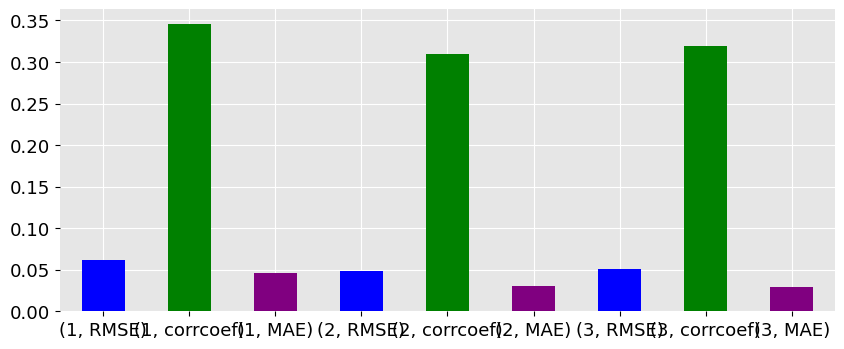

In [30]:
df_test_m.loc[0].plot.bar(rot=0, color=['blue', 'green', 'purple'], figsize=(10,4))

/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


(Coefficients  1..2..sst  1..1..sst
 1 0           -0.539109   0.178040
   1           -0.451285   0.257846
   2           -0.667453   0.363227
   3           -0.499510   0.297368,
 <Figure size 700x700 with 1 Axes>)

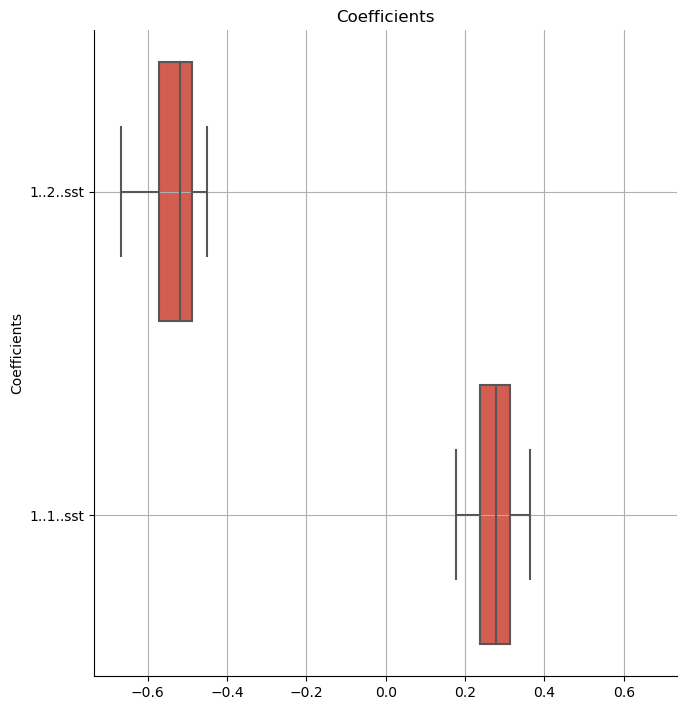

In [31]:
from stat_models import plot_importances
plot_importances(models_splits_lags=model_lags, lag=1)

### Match the retrieved timeseries of BivariateMI to the lag of forecasting 
Quick summary of code:

In [61]:
rg.list_for_MI[0].lags = np.array([0,1,2]) # update lags correlation map
rg.calc_corr_maps()
rg.cluster_list_MI()
rg.get_ts_prec()
rg.df_data


sst - calculating correlation maps
Progress traintest set 100%, trainsize=(270dp, 75%)


Getting MI timeseries
There are [2, 2, 2, 2] regions in total (list of different splits)


3ts  1..1..sst  1..2..sst  TrainIsTrue  RV_mask
0 1979-01-09 -7.601616  -0.038873   0.509949            0    False
  1979-01-19 -2.785106   0.378001   0.100344            0    False
  1979-01-29 -5.305454   0.191989   0.129262            0    False
  1979-02-08 -8.257336   0.209246  -0.107803            0    False
  1979-02-18 -5.436037   0.909116  -0.113632            0    False
...                ...        ...        ...          ...      ...
3 2018-07-18  0.193873  -1.140358  -0.071117            0     True
  2018-07-28 -2.411315  -1.285175   0.117341            0     True
  2018-08-07  0.672068  -1.214079  -0.041565            0     True
  2018-08-17 -0.586045  -0.958988  -0.214607            0     True
  2018-08-27 -0.029262  -0.957461  -0.187062            0     True

[5712 rows x 5 columns]

Above, we now have a timeseries of the correlation maps lag 0 up to lag 2. Below, we can match these timeseries to lag-of-forecast by setting 'match_lag_region_to_lag_fc' to True.

In [33]:
rg.fit_df_data_ridge(match_lag_region_to_lag_fc=True,
                    tau_min=0, tau_max=2)
# Predicitons for lag 0, 1 and 2 using precursors extraction from correlation maps at lag 0, 1, 2, respecitvely.

(                   3ts         0         1         2
 0 1979-06-08  0.276377 -0.806579 -0.618244 -0.115985
   1979-06-18  0.902123  0.097324 -0.597107 -0.487976
   1979-06-28 -2.251048  0.370561 -0.068759 -0.465526
   1979-07-08 -2.140842 -0.003022  0.012453 -0.123975
   1979-07-18 -1.012798 -0.670503 -0.195701 -0.100405
 ...                ...       ...       ...       ...
 3 2018-07-18  0.193873 -0.477142 -0.391564 -0.215633
   2018-07-28 -2.411315 -0.781369 -0.759647 -0.368178
   2018-08-07  0.672068 -0.698044 -1.125154 -0.776301
   2018-08-17 -0.586045 -0.486514 -0.849084 -1.074405
   2018-08-27 -0.029262 -0.343601 -0.436578 -0.827954
 
 [1440 rows x 4 columns],
 Empty DataFrame
 Columns: [0, 1, 2]
 Index: [],
 {'lag_0': {'split_0': RidgeCV(alphas=array([ 0.1,  1. , 10. ]), scoring='neg_mean_squared_error'),
   'split_1': RidgeCV(alphas=array([ 0.1,  1. , 10. ]), scoring='neg_mean_squared_error'),
   'split_2': RidgeCV(alphas=array([ 0.1,  1. , 10. ]), scoring='neg_mean_squared_er

## The arguments for using this package 
- Reproducible
- Flexible
- Time efficient

### An example of flexibility

In [58]:
# set up your pipeline
import func_models as fc_utils
def pipeline(tfreq, start_end_TVdate):
    rg = RGCPD(tfreq=tfreq, start_end_TVdate=start_end_TVdate)
    rg.list_for_MI = [BivariateMI(name='sst_test', distance_eps=700)]
    rg.pp_precursors() ; rg.pp_TV()
    rg.traintest('random_5')
    rg.calc_corr_maps() ; rg.cluster_list_MI()
    rg.get_ts_prec()
    target_ts = rg.TV.RV_ts ; 
    target_ts = (target_ts - target_ts.mean()) / target_ts.std()
    prediction = rg.fit_df_data_ridge(target=target_ts)[0]
    out = fc_utils.get_scores(prediction,
                              rg.df_data.iloc[:,-2:],
                              None,
                              n_boot = 0,
                              score_per_test=False,
                              blocksize=1)
    df_train_m, df_test_s_m, df_test_m, df_boot = out
    print(df_test_m.loc[0])  

Now lets choose a common timescale and target period for seasonal forecasts. 

In [59]:
pipeline(7, ('06-01','08-31')) 

initializing with test data
Loaded pre-processed data of sst_test

sorting latitude
original tfreq of imported response variable is converted to desired 7 (daily) means

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(416dp, 80%)


Getting MI timeseries
There are [2, 2, 2, 2, 2] regions in total (list of different splits)
1  mean_squared_error    0.885836
   corrcoef              0.336577
Name: 0, dtype: float64


With the code handling all the anoying data-handling stuff, one can easily test different settings. 

In [60]:
pipeline(15, ('07-01','08-31'))

initializing with test data
Loaded pre-processed data of sst_test

sorting latitude
original tfreq of imported response variable is converted to desired 15 (daily) means

sst - calculating correlation maps
Progress traintest set 100%, trainsize=(128dp, 80%)


Getting MI timeseries
There are [2, 2, 2, 2, 2] regions in total (list of different splits)
1  mean_squared_error    0.794768
   corrcoef              0.447739
Name: 0, dtype: float64


In [37]:
(0.885836 - 0.794768) / 0.794768

0.11458438185734696

Note a ~11% increase in skill (MSE). The commonly used target window and timescale had pourer predictability 
(likely has to due with dependence of temperature on end-of-summer soil moisture). 
\
\
When one codes a pipeline for 1 goal (7 day-mean forecast, JJA summer). He/she is restricted by the investment when testing other plausible hypothesis. With this Python package, users are freed from the coding time-investment and can spend more time on testing different hypthesis very efficiently.

A non-extensive list of options to test:
- Different timescales
- Different target window(s)
- Different precursors
- Different precursor extraction methods ((partial) correlation, EOF, ...)
- Different statistical model feature selection methods
- Different statistical models / tuning methods
- Different train-test splits
- Different definitions for the target

## (old) Forecasting pipeline 2 
Used for MWR paper https://doi.org/10.1175/MWR-D-19-0409.1

There is some multiprocessing based on Python's standard 'concurrent futures' module. This only works when run script is run in one go. Will not work another time. Has to do with the running the code as the __main__ file or something.. (don't know the details). 

In [38]:
rg.store_df_PCMCI() # storing timeseries in .h5 format
path_df_data = rg.path_df_data

Data stored in 
/Users/semvijverberg/surfdrive/Scripts/RGCPD/data/3ts_80d77_06-01-08-31_sst_leave_10s2_gap_p1_gap_a1/pcmci_max_combinations2max_conds_dim2max_conds_px2max_conds_py2pc_alpha0.05tau_max1tau_min0_dt10.h5


Now we load in the data, including info on the causal links. 

In [82]:
from class_fc import fcev
import valid_plots as dfplots

In [83]:
fc = fcev(path_data=path_df_data, n_cpu=1, causal=True)
fc.df_data

keys is None: Using all keys in training sets


/Users/semvijverberg/surfdrive/Scripts/RGCPD/forecasting/validation.py:543: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(traintest_yrs)


3ts  0..1..sst  0..2..sst  1..1..sst  1..2..sst  2..1..sst  \
0 1979-01-09 -7.601616   0.150370   0.405442  -0.038873   0.509949  -0.054080   
  1979-01-19 -2.785106   0.265549   0.089527   0.378001   0.100344   0.355517   
  1979-01-29 -5.305454   0.368152   0.080985   0.191989   0.129262   0.087675   
  1979-02-08 -8.257336   0.358585  -0.147099   0.209246  -0.107803   0.130419   
  1979-02-18 -5.436037   0.615753  -0.107907   0.909116  -0.113632   0.953445   
...                ...        ...        ...        ...        ...        ...   
3 2018-07-18  0.193873  -1.197670  -0.192635  -1.140358  -0.071117  -1.112603   
  2018-07-28 -2.411315  -1.269269  -0.035809  -1.285175   0.117341  -1.286627   
  2018-08-07  0.672068  -1.199466  -0.061862  -1.214079  -0.041565  -1.197398   
  2018-08-17 -0.586045  -1.022566  -0.128103  -0.958988  -0.214607  -0.936727   
  2018-08-27 -0.029262  -1.054774  -0.223942  -0.957461  -0.187062  -0.916100   

              2..2..sst  TrainIsTrue  RV_mask  
0 1979-01-09   0.511034            0    False  
  1979-01-19   0.072327            0    False  
  1979-01-29   0.156851            0    False  
  1979-02-08  -0.114490            0    False  
  1979-02-18  -0.121147            0    False  
...                 ...          ...      ...  
3 2018-07-18  -0.004799            0     True  
  2018-07-28   0.168429            0     True  
  2018-08-07  -0.003169            0     True  
  2018-08-17  -0.274935            0     True  
  2018-08-27  -0.223156            0     True  

[5712 rows x 9 columns]

In [84]:
fc.get_TV(kwrgs_events=None)

Define statmodel:

In [85]:
fc.fit_models?


Signature: fc.fit_models(lead_max=array([1]), verbosity=None)
Docstring:
stat_model_l:   list of with model string and kwrgs
keys_d      :   dict, with keys : list of variables to fit, if None
                all keys in each training set will be used to fit.
                If string is given, exp_py will follow some rules to
                keep only keys you want to fit.
precur_aggr:  int: convert daily data to aggregated {int} day mean
File:      ~/surfdrive/Scripts/RGCPD/forecasting/class_fc.py
Type:      method


In [86]:
fc.fit_models(lead_max=35)

tfreq: 10, max lag: 4, i.e. 35 days
('logit', None)


/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unk

in 1 seconds




/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)
/Users/semvijverberg/miniconda3/envs/RGCPD3/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['disp']
  warnings.warn(msg, ValueWarning)


In [87]:
dict_experiments = {}       
fc.perform_validation(n_boot=100, blocksize='auto', 
                              threshold_pred=(1.5, 'times_clim'))
dict_experiments['test'] = fc.dict_sum

In [88]:
fc.df_data


3ts  0..1..sst  0..2..sst  1..1..sst  1..2..sst  2..1..sst  \
0 1979-01-09 -7.601616   0.150370   0.405442  -0.038873   0.509949  -0.054080   
  1979-01-19 -2.785106   0.265549   0.089527   0.378001   0.100344   0.355517   
  1979-01-29 -5.305454   0.368152   0.080985   0.191989   0.129262   0.087675   
  1979-02-08 -8.257336   0.358585  -0.147099   0.209246  -0.107803   0.130419   
  1979-02-18 -5.436037   0.615753  -0.107907   0.909116  -0.113632   0.953445   
...                ...        ...        ...        ...        ...        ...   
3 2018-07-18  0.193873  -1.197670  -0.192635  -1.140358  -0.071117  -1.112603   
  2018-07-28 -2.411315  -1.269269  -0.035809  -1.285175   0.117341  -1.286627   
  2018-08-07  0.672068  -1.199466  -0.061862  -1.214079  -0.041565  -1.197398   
  2018-08-17 -0.586045  -1.022566  -0.128103  -0.958988  -0.214607  -0.936727   
  2018-08-27 -0.029262  -1.054774  -0.223942  -0.957461  -0.187062  -0.916100   

              2..2..sst  TrainIsTrue  RV_mask  
0 1979-01-09   0.511034            0    False  
  1979-01-19   0.072327            0    False  
  1979-01-29   0.156851            0    False  
  1979-02-08  -0.114490            0    False  
  1979-02-18  -0.121147            0    False  
...                 ...          ...      ...  
3 2018-07-18  -0.004799            0     True  
  2018-07-28   0.168429            0     True  
  2018-08-07  -0.003169            0     True  
  2018-08-17  -0.274935            0     True  
  2018-08-27  -0.223156            0     True  

[5712 rows x 9 columns]

In [89]:
working_folder, filename = fc._print_sett(list_of_fc=[fc])
store=True
dict_all = dfplots.merge_valid_info([fc], store=store)
if store:
    dict_merge_all = functions_pp.load_hdf5(filename)


Event settings:


***Experiment 1***


Title 	 : exper_2
file 	 : /Users/semvijverberg/surfdrive/Scripts/RGCPD/data/3ts_80d77_06-01-08-31_sst_leave_10s2_gap_p1_gap_a1/pcmci_max_combinations2max_conds_dim2max_conds_px2max_conds_py2pc_alpha0.05tau_max1tau_min0_dt10.h5
kwrgs_events 	 : {'event_percentile': 66, 'min_dur': 1, 'max_break': 0, 'grouped': False, 'window': 'mean'}
kwrgs_pp 	 : {}
TV dates: 	 ('6-8', '8-27')
tfreq: 	 10
precur_aggr: 	 None
TV_aggr: 	 None
alpha 	 : 0.05
nboot: 100
stat_models:
('logit', None)
fold: None
fc threshold: (1.5, 'times_clim')


/Users/semvijverberg/surfdrive/Scripts/RGCPD/forecasting/valid_plots.py:669: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']*n_bins)


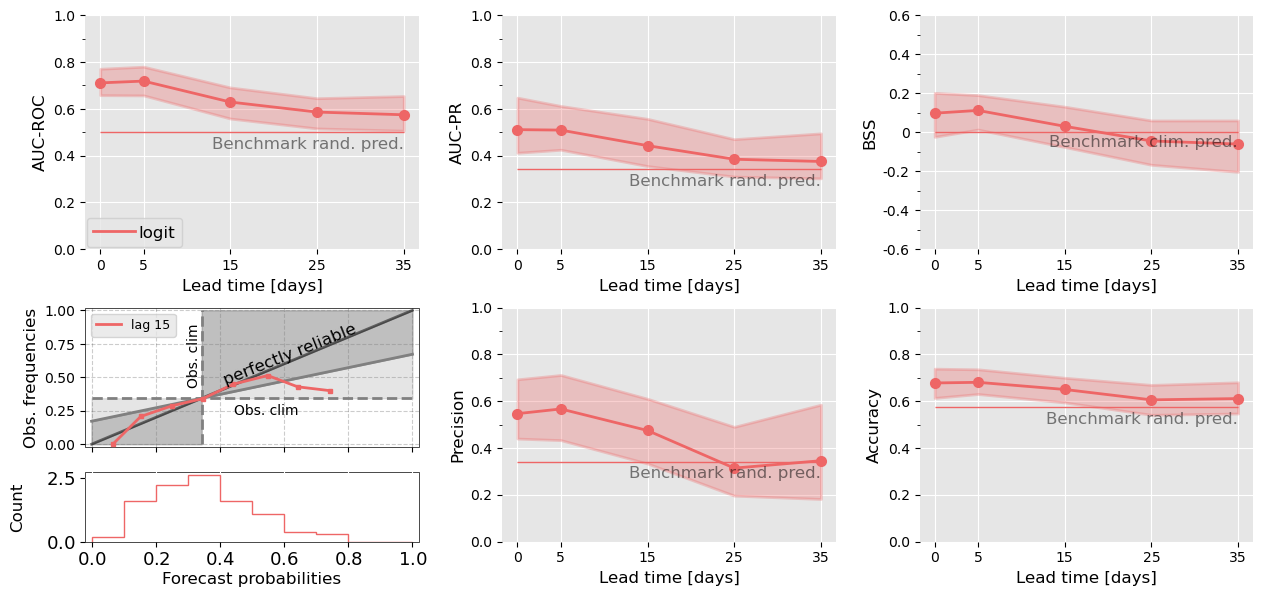

In [90]:

kwrgs = {'wspace':0.25, 'col_wrap':3} #, 'threshold_bin':fc.threshold_pred}
met = ['AUC-ROC', 'AUC-PR', 'BSS', 'Rel. Curve', 'Precision', 'Accuracy']
expers = list(dict_experiments.keys())
line_dim = 'model'


fig = dfplots.valid_figures(dict_merge_all, #expers=expers, #models=models,
                          line_dim=line_dim, 
                          group_line_by=None,  
                          met=met, **kwrgs)